# Exploring 3D Sinusoidal Data using Artificial Neural Networks

## Name: Blake Pritchard 

using artificial neural networks to solve simple regression problems.  
fit a neural network to a noisy 3D sinusoidal data set. use a `Sequential` model that can be trained very quickly on the supplied data, 

Here just just a few of the hyperparameters you can play around with:

- number of nodes per layer
- number of layers
- activation functions
- normalization method (should be negligible)
- number of epochs
- learning rate
- loss function

plot the model's prediction curve along with the training data.   

compute the generalization error on the test set.

## Preliminaries

Let's import some common packages:

In [1]:
#############################################
# Common imports

import os
import sys
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras


import keras.models
import keras.layers
import keras_tuner

from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

from scipy.stats import reciprocal

from scikeras.wrappers import KerasRegressor

np.set_printoptions(threshold=sys.maxsize)

2023-04-22 10:44:12.134343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [126]:
##############################################
# Plotting Functions

%matplotlib inline
# %matplotlib notebook
# %matplotlib qt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Label Style
axis_label_font = {'family':'serif','color':'darkred','size':12}


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

def plot3Ddata(data_df):
  
    # Build Sub-Plots
    figB = plt.figure(figsize=[15,15])
    subplotB1 = figB.add_subplot(221, projection='3d')
    subplotB2 = figB.add_subplot(222, sharex=subplotB1, sharey=subplotB1, projection='3d')
    subplotB3 = figB.add_subplot(223, sharex=subplotB1, sharey=subplotB1, projection='3d')
    subplotB4 = figB.add_subplot(224, sharex=subplotB1, sharey=subplotB1, projection='3d')

    # Set View Angles
    subplotB1.view_init(0, 90)
    subplotB2.view_init(34,0)
    subplotB3.view_init(45,90)
    subplotB4.view_init(90,90) 
    
    # Set Up Plots with Data and Labels
    subplotsB = [subplotB1, subplotB2, subplotB3, subplotB4]
    for plot in subplotsB:
    
        # Plot Points
        plot.scatter3D(data_df['x'], data_df['y'], data_df['z'], c='royalblue', alpha=0.6)  
        
        #Set Labels
        plot.set_xlabel('x', fontdict = axis_label_font)
        plot.set_ylabel('y', fontdict = axis_label_font)
        plot.set_zlabel('z', fontdict = axis_label_font)

    
def plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z):

    #Sort Data
    sort_df = pd.DataFrame(columns=['x', 'y', 'z', 'sort_order'])
    sort_df['x'] = fit_x
    sort_df['y'] = fit_y
    sort_df['z'] = fit_z
    sort_df.sort_values('z', ascending=True, inplace=True)
    
    #sort_df['sort_order']= sort_plot_points(sort_df)
    #sort_df.sort_index(inplace=True)
    
    # Build Sub-Plots
    figB = plt.figure(figsize=[15,15])
    subplotB1 = figB.add_subplot(221, projection='3d')
    subplotB2 = figB.add_subplot(222, sharex=subplotB1, sharey=subplotB1, projection='3d')
    subplotB3 = figB.add_subplot(223, sharex=subplotB1, sharey=subplotB1, projection='3d')
    subplotB4 = figB.add_subplot(224, sharex=subplotB1, sharey=subplotB1, projection='3d')
   
    # Set View Angles
    subplotB1.view_init(0, 90)
    subplotB2.view_init(34,0)
    subplotB3.view_init(45,90)
    subplotB4.view_init(90,90)
    
    # Set Up Plots with Data and Labels
    subplotsB = [subplotB1, subplotB2, subplotB3, subplotB4]
    for plot in subplotsB:
        
        #Plot Predicted Curve
        plot.plot3D(sort_df['x'], sort_df['y'], sort_df['z'], 'black')
        #plot.scatter3D(sort_df['x'], sort_df['y'], sort_df['z'], c='purple', alpha=0.6) 

        # Plot Points
        plot.scatter3D(scat_x, scat_y, scat_z, c='royalblue', alpha=0.6) 

        #Set Labels
        plot.set_xlabel('x', fontdict = axis_label_font)
        plot.set_ylabel('y', fontdict = axis_label_font)
        plot.set_zlabel('z', fontdict = axis_label_font)


# Import, Split and Standardize Data

Complete the following:



1. Begin by importing the data from the file called `3DSinusoidalANN.csv`.  Name the returned DataFrame `data`.

2. Call [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with a `test_size` of 20%.  Save the output into `X_train`, `X_test`, `y_train`, and `y_test`, respectively. Looking at the below graph, it makes sense for `x` and `z` to be your training data and `y` to be your response data.  Specify the `random_state` parameter to be `42` (do this throughout the entire note book).

3. Next, use the `StandardScaler()` to scale your data.

In [3]:
# Read CSV File
data = pd.read_csv('3DSinusoidalANN.csv')

In [4]:
X = data[['x','z']]
y = data[['y']]

# Split the Test and Training Set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the Training and Validation sets so we can perform early stopping
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [5]:
# Scale X
scaler_X = StandardScaler()
scaler_X.fit(X)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_valid_scaled = scaler_X.transform(X_valid)

In [6]:
# Scale y
scaler_y = StandardScaler()
scaler_y.fit(y)

y_train_scaled=scaler_y.transform(y_train)
y_test_scaled=scaler_y.transform(y_test)
y_valid_scaled = scaler_y.transform(y_valid)

In [7]:
# Convert to DataFrames
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_valid = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

y_train = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)
y_test = pd.DataFrame(y_test_scaled, columns=y_test.columns, index=y_test.index)
y_valid = pd.DataFrame(y_valid_scaled, columns=y_valid.columns, index=y_valid.index)

# Plot Data

Simply plot your training data here, so that you know what you are working with.  You must define a function called `plot3Ddata`, which accepts a Pandas DataFrame (composed of 3 spatial coordinates) and uses `scatter3D()` to plot the data.  Use this function to plot only the training data (recall that you don't even want to look at the test set, until you are ready to calculate the generalization error).  You must place the definition of this function in the existing code cell of the above __Preliminaries__ section, and have nothing other than the function invocation in the below cell. 

You must emulate the graphs shown in the respective sections below. Each of the graphs will have four subplots. Note the various viewing angles that each subplot presents - you can achieve this with the view_init() method. Be sure to label your axes as shown.

In [8]:
# Shared Values for Standardized Plots
fit_x = X_train['x']
fit_z = X_train['z']

scat_x = X_train['x']
scat_y = y_train
scat_z = X_train['z']

In [9]:
# Add Training Label Values
train_df = pd.DataFrame(X_train, columns=['x','z'])
train_df['y'] = y_train

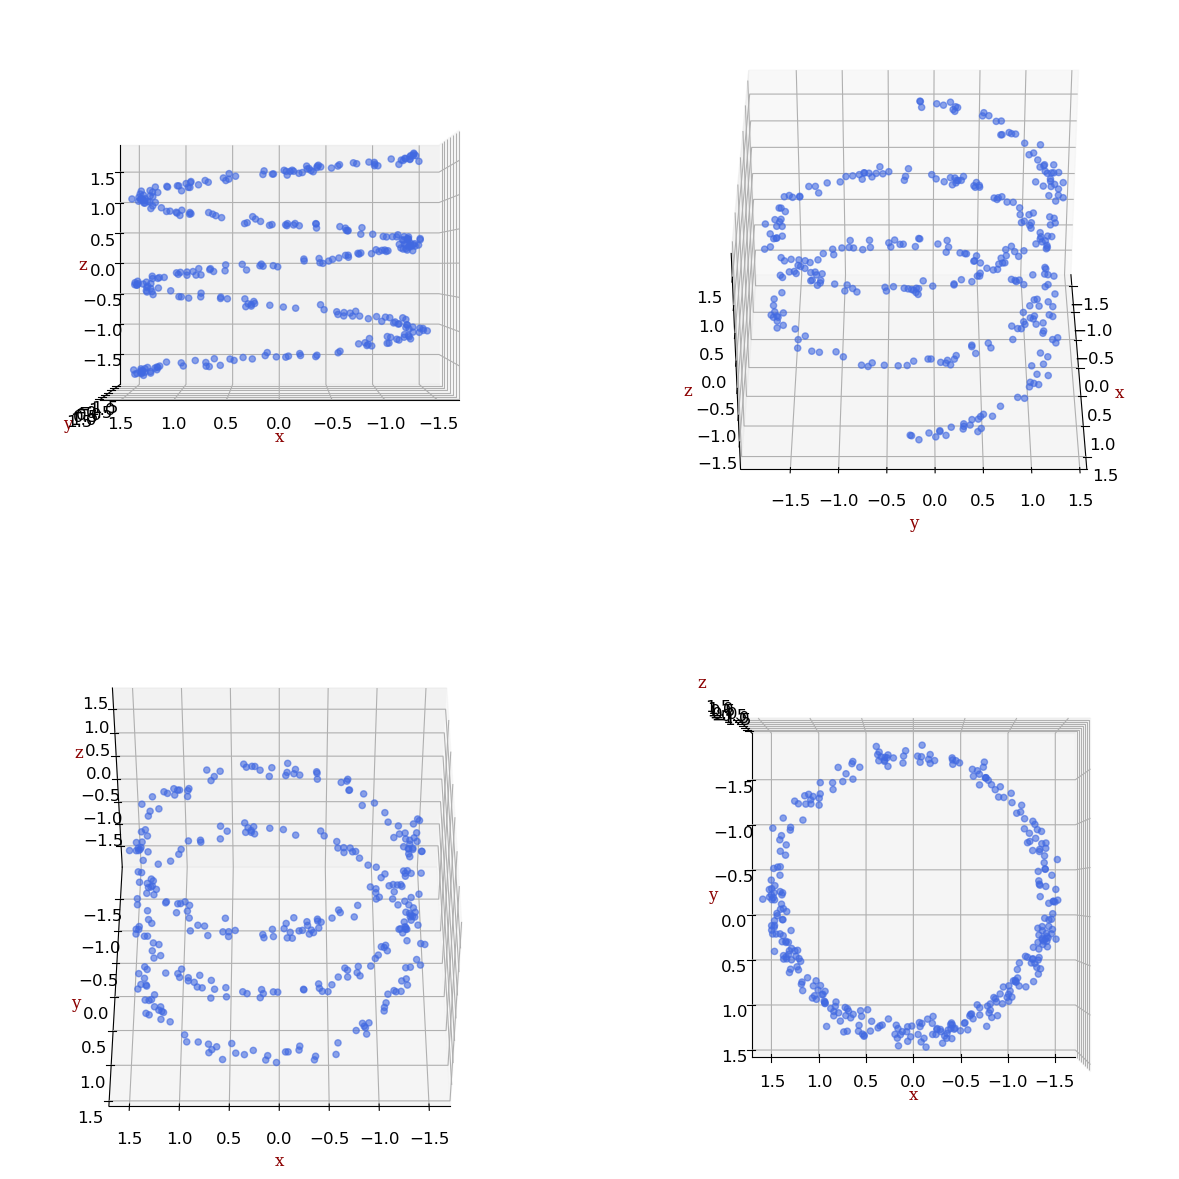

In [10]:
# Plot Training Data
plot3Ddata(train_df)

## A Quick Note

In the following sections you will be asked to plot the training data along with the model's predictions for that data superimposed on it.  You must write a function called `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` that will plot this figure.  The function accepts six parameters as input, shown in the function signature.  All six input parameters must be NumPy arrays.  The three Numpy arrays called `fit_x, fit_y,` and  `fit_z` represent the x, y, and z coordinates of the model predictions (i.e. the prediction curve).  The three Numpy arrays called `scat_x, scat_y,` and  `scat_z` represent the x, y, and z coordinates of the training data.   

You must place the definition of the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function in the existing code cell of the above __Preliminaries__ section. (The function header is already there - you must complete the function definition.)  You will use the `plotscatter3Ddata()` function in the following section.

# Explore 3D Sinusoidal Data with Artifical Neural Networks

Fit a `Sequential` model to this data.  You must manually assign values to the hyperparameters, including the number of nuerons per layer and the number of layers.  You should "play around" by using different combinations of hyperparameter values.  When you are done playing, you should build an ANN that models the data well.  Then, you will use that modelto calculate the generalization error in the subsequent section.

### Build Models Programmatically

In [91]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, n_batch_size=8, input_shape=[2], activation_function='relu', loss_function='mse'):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation_function))
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=optimizer)
        
    return model

In [92]:
def plot_learning_curve(model_training_history):
    pd.DataFrame(model_training_history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    save_fig("keras_learning_curves_plot_b")
    plt.show()

In [93]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, input_shape=X_train.shape[1:])

/tmp/ipykernel_933763/3191813220.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, input_shape=X_train.shape[1:])


---
## Randomized Search for number and size of layers

### Best Hyperparameters So Far:
* 'activation_function': 'relu',
* 'learning_rate': 0.010333069990112522,
* 'n_hidden': 8,
* 'n_neurons': 77}

### Most Optimal Search Parameters So Far:
*    "n_hidden": 1-96,
*    "n_neurons": 3-96,
*    "learning_rate": reciprocal(3e-4, 3e-2),

### Widest Parameters Searched:
*  "n_hidden": 1-96,
*  "n_neurons": 1-500,
*  "learning_rate": reciprocal(3e-4, 3e-2),
*  "activation_function": ['relu', 'linear', 'sigmoid', 'tanh', 'step']
*  "loss_function": ['mean_squared_error', 'cosine_similarity', 'mean_squared_logarithmic_error', 'mean_absolute_error']

In [94]:
param_distribs = {
                    "n_hidden": np.arange(1, 96, 1),
                    "n_neurons": np.arange(3, 96, 1),
                    "learning_rate": reciprocal(3e-4, 10),
                    "activation_function": ['relu'],
                    "loss_function": ['mean_squared_error'],
                    "batch_size": np.arange(1, 32, 1)
                  }

In [95]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_jobs=4, n_iter=400, cv=3)

In [ ]:
%%time
rnd_search_cv.fit(X_train, 
                  y_train, 
                  epochs=300, 
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                  # verbose=0
                 )

### Log Entries Truncated for notebook brevity...

### CPU times: user 48.1 s, sys: 10.9 s, total: 59 s
### Wall time: 1h 25min 42s
    
RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f1f597eadf0>,
                   n_iter=400, n_jobs=4,
                   param_distributions={'activation_function': ['relu'],
                                        'batch_size': array(...),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen...
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
                                        'n_neurons': array(...)})


In [97]:
rnd_search_cv.best_params_

{'activation_function': 'relu',
 'batch_size': 24,
 'learning_rate': 0.0035472593594117674,
 'loss_function': 'mean_squared_error',
 'n_hidden': 8,
 'n_neurons': 77}

In [98]:
rnd_search_cv.best_score_

-0.04247728114326795

### Select and Evaluate Best Model

In [99]:
model = rnd_search_cv.best_estimator_.model

In [100]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_122 (Dense)           (None, 77)                231       
                                                                 
 dense_123 (Dense)           (None, 77)                6006      
                                                                 
 dense_124 (Dense)           (None, 77)                6006      
                                                                 
 dense_125 (Dense)           (None, 77)                6006      
                                                                 
 dense_126 (Dense)           (None, 77)                6006      
                                                                 
 dense_127 (Dense)           (None, 77)                6006      
                                                                 
 dense_128 (Dense)           (None, 77)               

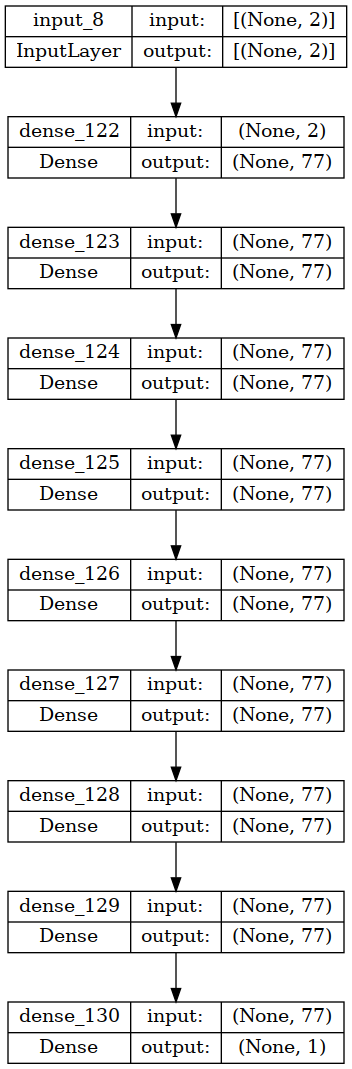

In [102]:
keras.utils.plot_model(model, "assignment_7_best_model.png", show_shapes=True)

### Plot Loss Function
Lets Plot the loss so we can get a baseline for how it learns before we tune the Learning Rate

Saving figure keras_learning_curves_plot_b


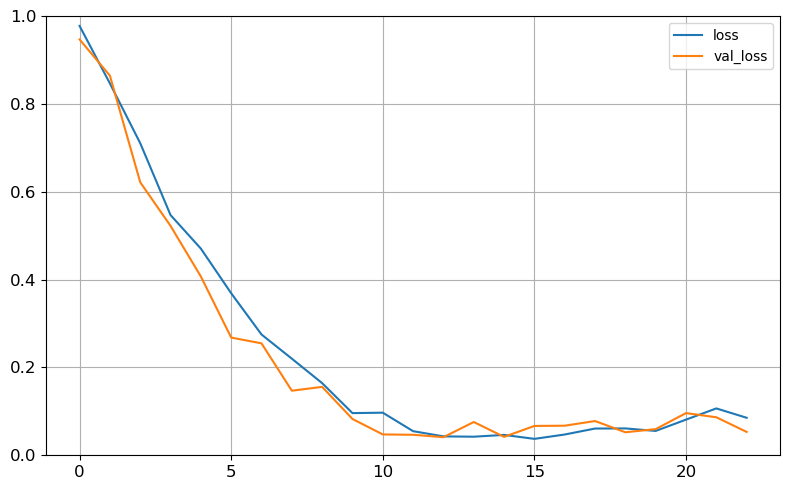

In [101]:
plot_learning_curve(model.history.history)

In [103]:
# Run Model on Training Set to Generate Plot Predictions
array_fit_y = model.predict(X_train).astype(np.float64)
fit_y = pd.Series(array_fit_y.ravel(), name='z', index = X_train.index)

11/11 [==============================] - 0s 3ms/step


In [105]:
# Run Model on Test Set to Evaluate Performance
mse_test = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0378


In [106]:
str_mse_test = str(np.round(mse_test, 4))

### MSE Before we Tune the Learning Rate:

In [107]:
print("the Mean Squared Error of the Predictions on the Test Set is:" + str_mse_test)

the Mean Squared Error of the Predictions on the Test Set is:0.0378


---
## Grid Search with Best Model Parameters to find Optimal Learning Rate
now that we have selected the model architecture we will re-train to find the optimal learning rate

{'activation_function': 'relu',
 'batch_size': 24,
 'learning_rate': 0.0035472593594117674,
 'loss_function': 'mean_squared_error',
 'n_hidden': 8,
 'n_neurons': 77}

In [121]:
new_model_params = {
                        'activation_function': ['relu'],
                        'learning_rate': np.linspace(3e-4,3e-2),
                        'loss_function': ['mean_squared_error'],
                        'n_hidden': [8],
                        'n_neurons': [77]
                    }

In [122]:
grd_search_cv = GridSearchCV(keras_reg, new_model_params, n_jobs=4, cv=3)

In [111]:
%%time
grd_search_cv.fit(X_train, 
                  y_train, 
                  epochs=30, 
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                  # verbose=0
                 )

### Log Entries Truncated for notebook brevity...

### CPU times: user 7.84 s, sys: 1.15 s, total: 8.99 s
### Wall time: 4min 5s

In [150]:
grd_search_cv.best_params_

{'activation_function': 'relu',
 'learning_rate': 0.0021183673469387754,
 'loss_function': 'mean_squared_error',
 'n_hidden': 8,
 'n_neurons': 77}

In [151]:
grd_search_cv.best_score_

-0.04595254299541315

### Select and Evaluate Best Learning Rate
After we tune our learning rate, we can see that our Loss stabilizes nicely after just a few training epochs

In [152]:
new_model = grd_search_cv.best_estimator_.model

Saving figure keras_learning_curves_plot_b


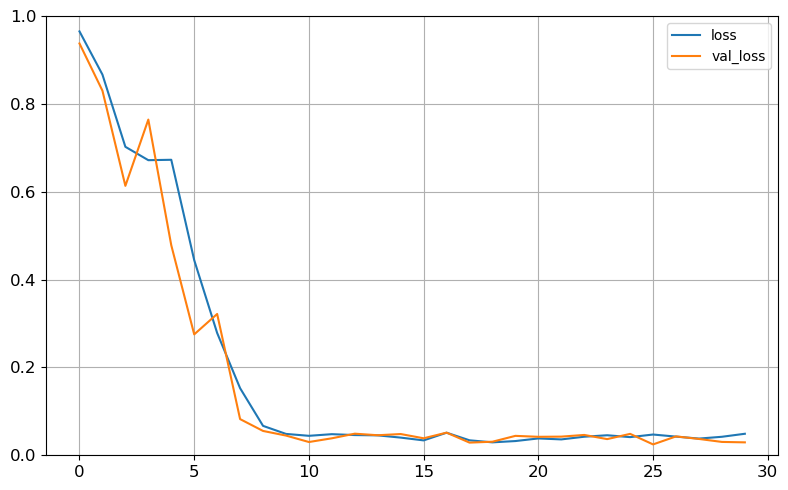

In [153]:
plot_learning_curve(new_model.history.history)

---
### Plot Model Predictions for Training Set

Use the model's `predict()` method to make a prediction for `y` using the `x` and `z` training data.  Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

In [154]:
# Run Model on Training Set to Generate Plot Predictions
new_array_fit_y = new_model.predict(X_train).astype(np.float64)
new_fit_y = pd.Series(new_array_fit_y.ravel(), name='y', index = X_train.index)

11/11 [==============================] - 0s 2ms/step


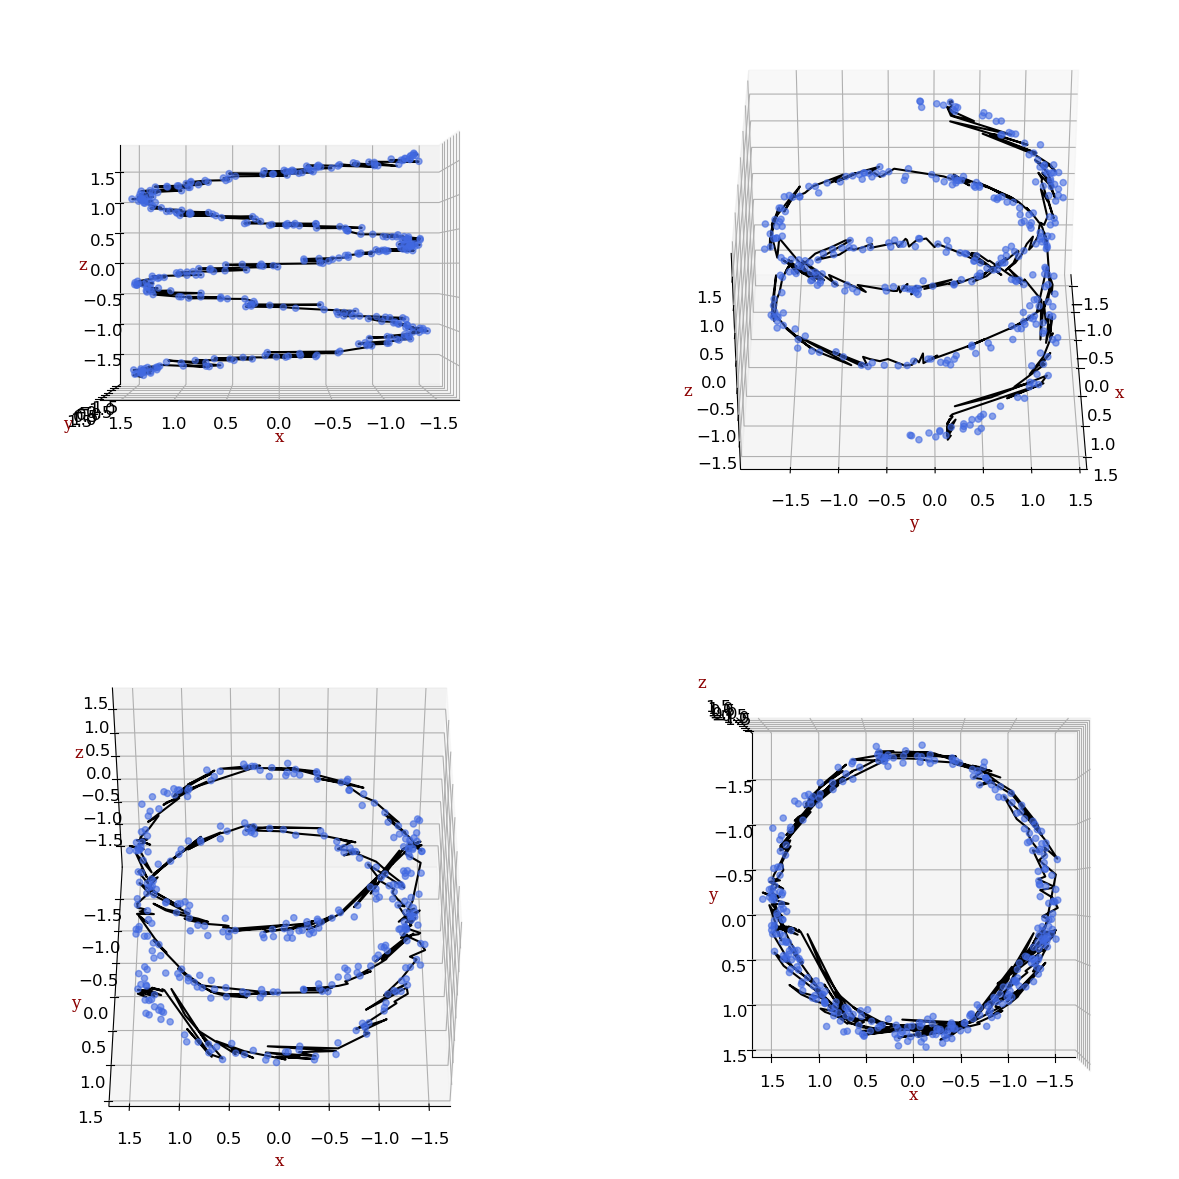

In [155]:
plotscatter3Ddata(fit_x, new_fit_y, fit_z, scat_x, scat_y, scat_z)

# Compute Generalization Error

Compute the generalization error and use MSE as the generalization error metric.  Round your answers to four decimal places.  Print the generalization error for the model.

In [156]:
# Run Model on Test Set to Evaluate Performance
new_mse_test = new_model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 6ms/step - loss: 0.0239


### MSE After we Tuned the Learning Rate:

In [157]:
print("the Mean Squared Error of the Predictions on the Test Set is:" + str(np.round(new_mse_test, 4)))

the Mean Squared Error of the Predictions on the Test Set is:0.0239


### An MSE of:  0.0239 is a nice improvement!